##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: All about tokens

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Counting_Tokens.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


An understanding of tokens is central to using the Gemini API. This guide will provide a interactive introduction to what tokens are and how they are used in the Gemini API.

## About tokens

LLMs break up their input and produce their output at a granularity that is smaller than a word, but larger than a single character or code-point.

These **tokens** can be single characters, like `z`, or whole words, like `the`. Long words may be broken up into several tokens. The set of all tokens used by the model is called the vocabulary, and the process of breaking down text into tokens is called tokenization.

For Gemini models, a token is equivalent to about 4 characters. **100 tokens are about 60-80 English words**.

When billing is enabled, the price of a paid request is controlled by the [number of input and output tokens](https://ai.google.dev/pricing), so knowing how to count your tokens is important.


## Tokens in the Gemini API

In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
import google.generativeai as genai

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

### Context windows

The models available through the Gemini API have context windows that are measured in tokens. These define how much input you can provide, and how much output the model can generate, and combined are referred to as the "context window". This information is available directly through [the API](https://ai.google.dev/api/rest/v1/models/get) and in the [models](https://ai.google.dev/models/gemini) documentation.

In this example you can see the `gemini-1.5-flash` model has an 1M tokens context window. If you need more, `gemini-1.5-pro-latest` has an even bigger 2M tokens context window.

In [2]:
model_info = genai.get_model('models/gemini-1.5-flash')
(model_info.input_token_limit, model_info.output_token_limit)

(1048576, 8192)

## Counting tokens

The API provides an endpoint for counting the number of tokens in a request: [`GenerativeModel.count_tokens`](https://ai.google.dev/api/python/google/generativeai/GenerativeModel#count_tokens). You pass the same arguments as you would to [`GenerativeModel.generate_content`](https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content) and the service will return the number of tokens in that request.

### Text tokens

In [3]:
model = genai.GenerativeModel('models/gemini-1.5-flash')
model.count_tokens("The quick brown fox jumps over the lazy dog.")

total_tokens: 10

When you call `GenerativeModel.generate_content` (or `ChatSession.send_message`) the response object has a `usage_metadata` attribute containing both the input and output token counts (`prompt_token_count` and `candidates_token_count`):

In [4]:
response = model.generate_content("The quick brown fox jumps over the lazy dog.")
print(response.text)

This is a classic sentence! It's often used as an example because it contains all 26 letters of the English alphabet. 

Is there anything specific you'd like to know about this sentence, or are you just enjoying its famous status? 😊 



In [5]:
response.usage_metadata

### Multi-turn tokens

Multi-turn conversational (chat) objects work similarly.

In [6]:
chat = model.start_chat(history=[{'role':'user', 'parts':'Hi my name is Bob'},  {'role':'model', 'parts':'Hi Bob!'}])
model.count_tokens(chat.history)

total_tokens: 10

In [7]:
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash',
        generation_config={},
        safety_settings={},
        tools=None,
        system_instruction=None,
    ),
    history=[genai.protos.Content({'parts': [{'text': 'Hi my name is Bob'}], 'role': 'user'}), genai.protos.Content({'parts': [{'text': 'Hi Bob!'}], 'role': 'model'})]
)

To understand how big your next conversational turn will be, you will need to append it to the history when you call `count_tokens`.

In [8]:
from google.generativeai.types.content_types import to_contents
model.count_tokens(chat.history + to_contents('What is the meaning of life?'))

total_tokens: 17

### Multi-modal tokens

All input to the API is tokenized, including images or other non-text modalities.

In [9]:
!curl -L https://goo.gle/instrument-img -o organ.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   221  100   221    0     0    812      0 --:--:-- --:--:-- --:--:--   812
100  374k  100  374k    0     0  1287k      0 --:--:-- --:--:-- --:--:-- 1287k


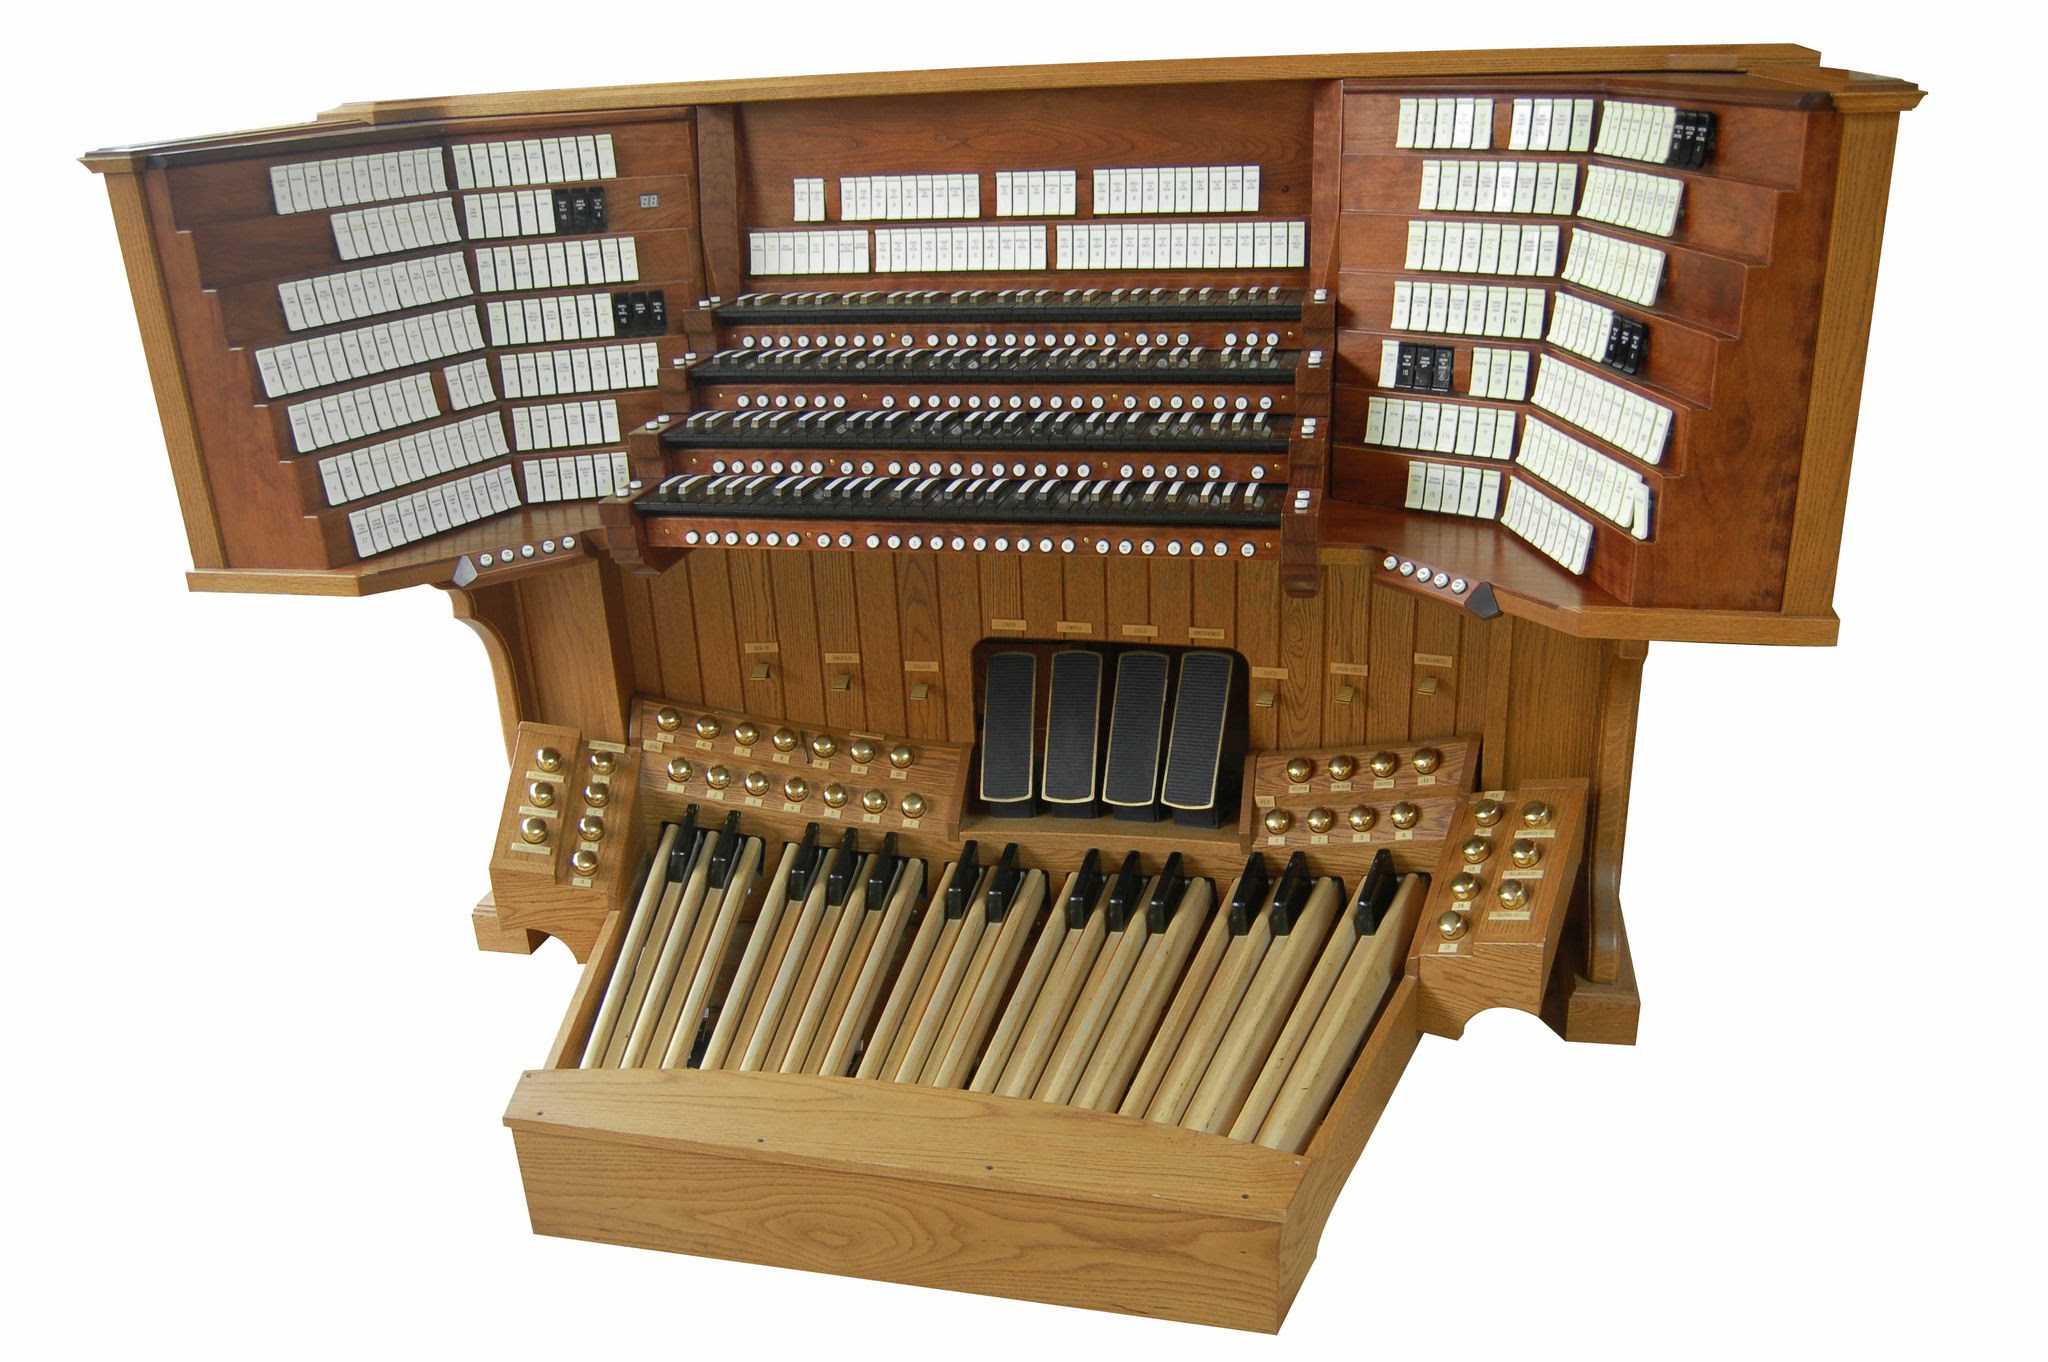

In [10]:
import PIL
from IPython.display import display, Image

display(Image('organ.jpg', width=300))

#### Inline content

Media objects can be sent to the API inline with the request:

In [11]:
organ = PIL.Image.open('organ.jpg')
model.count_tokens(['Tell me about this instrument', organ])

total_tokens: 263

#### Files API

The model sees identical tokens if you upload parts of the prompt through the files API instead:

In [12]:
organ_upload = genai.upload_file('organ.jpg')

model.count_tokens(['Tell me about this instrument', organ_upload])

total_tokens: 263

### Media token counts

Internally, images are a fixed size, so they consume a fixed number of tokens.

In [13]:
!curl -O "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg" --silent

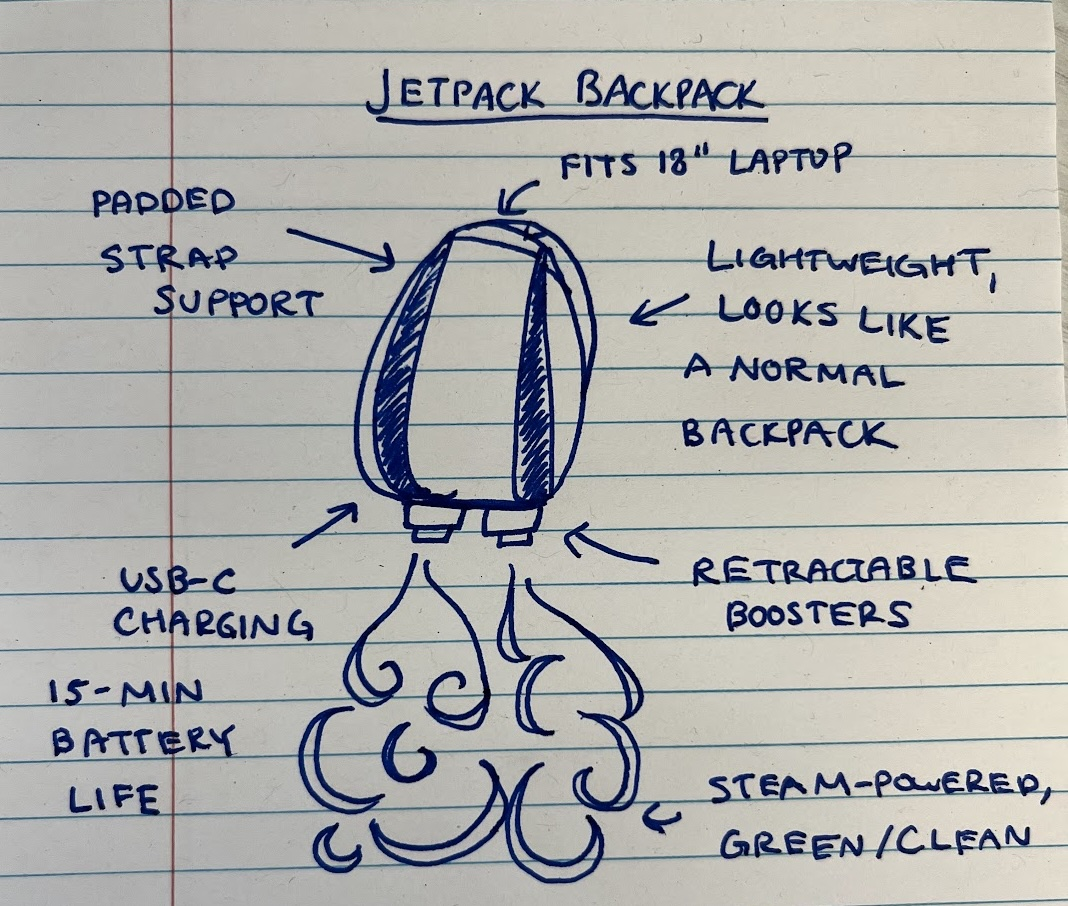

In [14]:
jetpack = PIL.Image.open('jetpack.jpg')
display(Image('jetpack.jpg', width=300))

In [15]:
print(organ.size)
print(model.count_tokens(organ))

print(jetpack.size)
print(model.count_tokens(jetpack))

(2048, 1362)
total_tokens: 258

(1068, 906)
total_tokens: 258



Audio and video are each converted to tokens at a fixed rate of tokens per minute.

In [16]:
!curl -q -o sample.mp3  "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.8M  100 39.8M    0     0   146M      0 --:--:-- --:--:-- --:--:--  146M


In [17]:
audio_sample = genai.upload_file('sample.mp3')
model.count_tokens(audio_sample)

total_tokens: 83552

### System instructions and tools

System instructions and tools also count towards the total:

In [18]:
genai.GenerativeModel().count_tokens("The quick brown fox jumps over the lazy dog.")

total_tokens: 10

In [19]:
genai.GenerativeModel(system_instruction='Talk like a pirate!').count_tokens("The quick brown fox jumps over the lazy dog.")

total_tokens: 15

In [20]:
def add(a:float, b:float):
    """returns a + b."""
    return a+b

def subtract(a:float, b:float):
    """returns a - b."""
    return a-b

def multiply(a:float, b:float):
    """returns a * b."""
    return a*b

def divide(a:float, b:float):
    """returns a / b."""
    return a*b

model = genai.GenerativeModel(model_name='gemini-1.5-flash',
                              tools=[add, subtract, multiply, divide])
model.count_tokens("The quick brown fox jumps over the lazy dog.")

total_tokens: 194

## Further reading

For more on token counting, check out the API reference.

* [countTokens](https://ai.google.dev/api/rest/v1/models/countTokens) REST API reference,
* [count_tokens](https://ai.google.dev/api/python/google/generativeai/GenerativeModel#count_tokens) Python API reference,